# Problema

En 2020 la ISSMGE LATAM lanzó un desafío a sus miembros con el objetivo de ver que tanto se sobredimensionan en la práctica varias estructuras geotécnicas (zapatas, pilotes, taludes y excavaciones).

Uno de ellos se trata del cálculo de la capacidad de carga de un pilote en arcilla cargado axialmente.

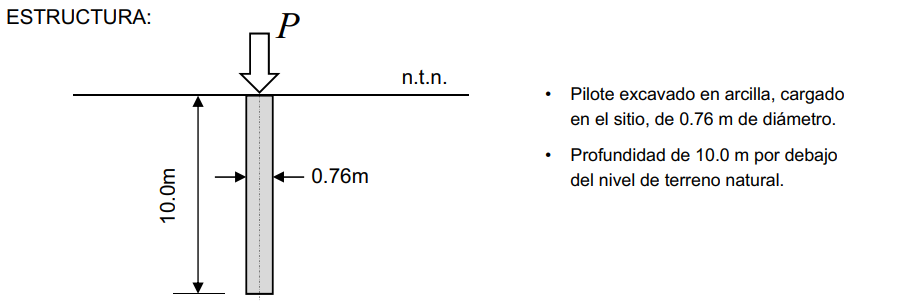



Adicionalmente, se proveyó de información sobre el perfil del terreno y resultados de ensayos de laboratorio e in-situ.

## Perfil del suelo

El perfil arcilloso es predominantemente de origen aluvial y es sobreconsolidado.

El perfil puede ser descripto como sigue:

* 0 – 5.5 m Arcilla muy rígida
* 5.5 – 6.5 m Lentes de Arena medianamente densa (intermitente)
* 6.5 – 12.0 m Arcilla muy rígida
* 12.0 m + Esquisto altamente intemperizado.

La profundidad del Nivel Freático es de aproximadamente 6m por debajo de la
superficie.


## Ensayos de laboratorio

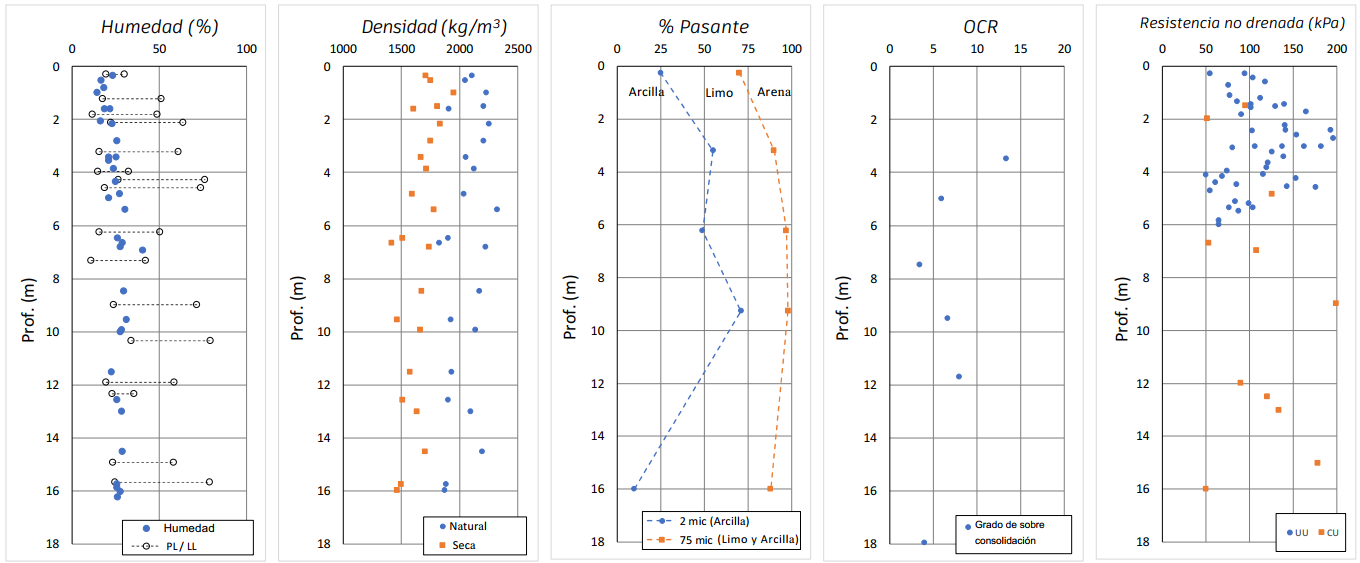



## Ensayos in-situ

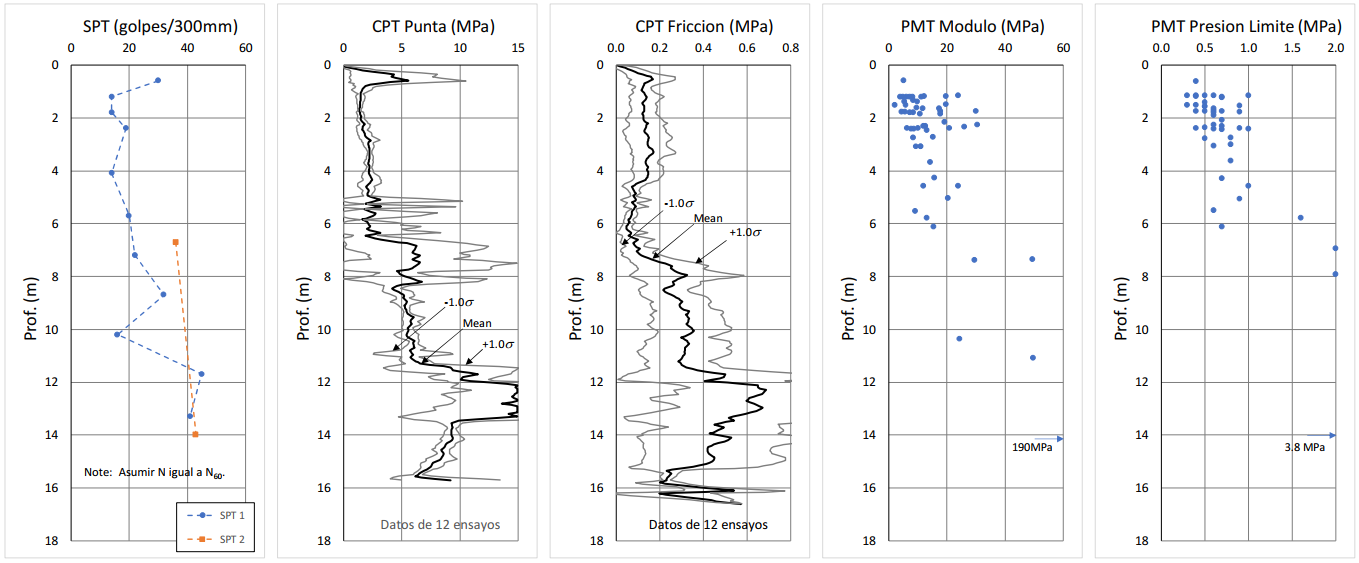

# Resolución determinística

Solamente nos enfocaremos en la resistencia por fuste del pilote para este ejemplo. Vamos a calcular la resistencia por fuste en condición drenada y no drenada con las teorías vistas en clase y seleccionando parámetros a partir de la inspección visual de los ensayos.

## Resistencia drenada

Consideramos las fórmula:

$f_s = K \cdot \sigma'_v \cdot tan(\delta)$

Donde:

*   $K_0 < K < 1.0$ para pilotes perforados
*   $\delta = 3/4 \cdot \phi'$ para pilotes de hormigón

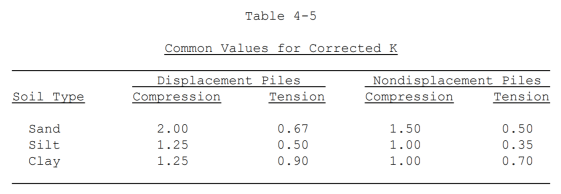

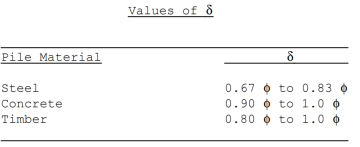

Por lo que necesitamos determinar $\phi'$ a partir de los resultados de los ensayos. Evidentemente no se cuenta con triaxiales drenados por lo que usaremos correlaciones para definirlo.

### Correlación entre IP y $\phi_{cv}$

EPRI (1990) - Manual on estimating soil properties for foundation design (pag 4-22)

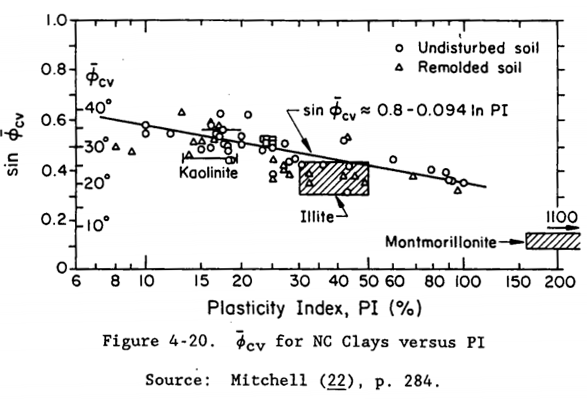

EL IP está alrededor de 40% en toda los primeros 10m del terreno, por lo que $\phi_{cv}\approx 27°$.

Como se trata de una arcilla sobreconsolidada, estimamos el $\phi$ en función del OCR con:

$tan(\phi) \approx 1.2 \cdot \sqrt{ln (OCR)} \cdot tan(\phi_{cv})$

Asumiendo un $OCR=5$, $\phi=37°$



### Funciones para el cálculo

Tensión vertical efectiva

In [171]:
import numpy as np
from scipy.integrate import quad

Tensión vertical efectiva

In [172]:
def tension_vertical_efectiva(z,gamma,limites,nf,n_layers):
  
  tension_vertical_total = 0

  #Cálculo de tensión vertical total
  for i in range(n_layers): #loop por los estratos
    if z > limites[i+1]: #significa que el punto está por debajo del estrato
      h_estrato = limites[i+1]-limites[i]
    elif z > limites[i] and z <= limites[i+1]: #significa que el punto esta en el medio del estrato
      h_estrato = z-limites[i]
    else:
      h_estrato = 0
    tension_vertical_total = tension_vertical_total + gamma[i]*h_estrato
  #Cálculo de presión neutra
  if z<=nf:
    presion_neutra = 0
  if z>nf:
    presion_neutra = (z-nf)*10
  
  #Cálculo de tensión vertical efectiva
  tension_vertical_efectiva = tension_vertical_total - presion_neutra
    
  return tension_vertical_efectiva

Tension horizontal efectiva

In [173]:
def tension_horizontal_efectiva(z,gamma,limites,K,nf,n_layers): 

  sigmav_eff = tension_vertical_efectiva(z,gamma,limites,nf,n_layers) #calculo de tension vertical en z

  for i in range(n_layers): #loop por los estratos
    if z > limites[i] and z <= limites[i+1]: #encuentro el estrato en donde estamos para elegir K0
      tension_horizontal_efectiva = sigmav_eff * K[i]

  return tension_horizontal_efectiva

Resistencia por fricción en interfaz suelo-hormigón

In [174]:
def resistencia_unitaria_friccion(z,limites,phi,gamma,K0,nf):
  n_layers = len(gamma) #cantidad de estratos

  sigmah_eff = tension_horizontal_efectiva(z,gamma,limites,K0,nf,n_layers) #calculo de tension horizontal en z

  for i in range(n_layers): #loop por los estratos
    if z > limites[i] and z <= limites[i+1]: #encuentro el estrato en donde estamos para elegir K0
      delta = 3/4 * np.deg2rad(phi[i]) #pilote de hormigón

  fs = sigmah_eff * delta
  
  return fs

Resistencia por fuste

In [175]:
def resistencia_por_fuste(L,limites,phi,gamma,K0,nf,D):
  #Limites de la integración
  zi=0
  zf=L

  #Integración numérica de la función resistencia_unitaria_friccion entre 0 y L
  qf = quad(resistencia_unitaria_friccion,zi,zf,(limites,phi,gamma,K0,nf))

  #Perímetro del pilote
  per = np.pi*D

  #Resistencia última por fuste total
  Qf = qf[0]*per #la función quad devuelve una lista con 0: resultado y 1:error, uso solo el resultado

  return Qf

### Cálculo de la resistencia

Datos

In [176]:
#Limites de los estratos, en m
limites = [0,10]

# Peso propio, en kN/m3
gamma = [20]

# Ángulo de fricción
phi = [37]

# Módulo de empuje horizontal
K = [0.75]

#Profundidad del nivel freático, en m
nf = 6

#Diametro del pilote, en m
D = 0.76

#Profundidad del pilote, en m
L = 10

Evaluación de las funciones

In [177]:
Qf = resistencia_por_fuste(L,limites,phi,gamma,K,nf,D)
print(f'Resistencia por fuste en condición drenada, Qf={Qf:.0f}kN')

Resistencia por fuste en condición drenada, Qf=798kN


## Resistencia no drenada

Parece haber dos comportamientos a juzgar por los resultados del ensayo CPTu, de 0 a 6m y de 6 a 12.

Vamos a hacer dos hipótesis importantes:

1. La data de resistencia por punta ya tiene corrección por presiones de poro.
2. Al ser arcilla, no hay drenaje parcial con la penetración del cono.

Luego podemos definir la resistencia no drenada (pico) como:

$s_u = (q_t-\sigma_v)/N_{kt}$, con $N_{kt}=14$

Adoptamos:

$q_t = 150 kPa$ para $0m<z<6m$

$q_t = 380 kPa$ para $6m<z<12m$

Utilizando el método $\alpha$, la fricción lateral la estimamos como

$f_s = \alpha \cdot s_u$

$\alpha = 0.21 + \frac{26kPa}{s_u} \leq 1.0$

### Funciones para el cálculo

Tensión vertical total

In [178]:
def tension_vertical_total(z,gamma,limites,nf,n_layers):
  
  tension_vertical_total = 0

  #Cálculo de tensión vertical total
  for i in range(n_layers): #loop por los estratos
    if z > limites[i+1]: #significa que el punto está por debajo del estrato
      h_estrato = limites[i+1]-limites[i]
    elif z > limites[i] and z <= limites[i+1]: #significa que el punto esta en el medio del estrato
      h_estrato = z-limites[i]
    else:
      h_estrato = 0
    tension_vertical_total = tension_vertical_total + gamma[i]*h_estrato
    
  return tension_vertical_total

Alfa

In [179]:
def fs_metodo_alpha(su):

  if su==0:
    return 0

  alpha = 0.21 + 26/su
  if alpha>=1:
    alpha=1

  fs = alpha*su

  return fs

### Cálculo de resistencia

Datos

In [180]:
# Resistencia del terreno
su1 = 150 #entre 0 y 6m, en kPa
su2 = 380 #entre 6m y 12m, en kPa

L1 = 6 #longitud del primer tramo, en m
L2 = 4 #longitud del segundo tramo, en m

per = np.pi*D #perimetro del pilote, en m2

Resistencia unitaria

In [181]:
fs1 = fs_metodo_alpha(su1) #resistencia al fuste unitaria del primer tramo, en kPa
fs2 = fs_metodo_alpha(su2) #resistencia al fuste unitaria del segundo tramo, en kPa

print(f'fs1={fs1:.0f}kPa; fs2={fs2:.0f}kPa')

fs1=57kPa; fs2=106kPa


Resistencia total

In [182]:
Qf = (fs1 * L1 + fs2 * L2) * per

print(f'Resistencia por fuste en condición no-drenada, Qf={Qf:.0f}kN')

Resistencia por fuste en condición no-drenada, Qf=1834kN


# Resolución probabilística

Para la determinación de una resistencia última en forma probabilística, vamos a incorporar en el análisis la incertidumbre proveniente de los ensayos y las correlaciones utilizadas.

Vamos a asumir que no existe un sesgo en los resultados de laboratorio y que la variabilidad es inherente al terreno.

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

## Resistencia drenada

### Índice de plasticidad

Importo los datos

In [184]:
limites = pd.read_csv("/content/limites.txt")
limites

,Profundidad,LP,LL
0,0.29,19.7,30.2
1,1.21,17.8,51.4
2,1.82,11.8,48.7
3,2.12,22.4,63.6
4,3.21,15.6,60.8
5,3.96,14.8,32.6
6,4.26,26.5,76.0
7,4.58,18.9,73.8
8,6.25,15.7,50.3
9,7.32,11.1,42.4


Calculo el índice de plasticidad

In [185]:
limites["IP"] = limites["LL"] - limites["LP"]
limites

,Profundidad,LP,LL,IP
0,0.29,19.7,30.2,10.5
1,1.21,17.8,51.4,33.6
2,1.82,11.8,48.7,36.9
3,2.12,22.4,63.6,41.2
4,3.21,15.6,60.8,45.2
5,3.96,14.8,32.6,17.8
6,4.26,26.5,76.0,49.5
7,4.58,18.9,73.8,54.9
8,6.25,15.7,50.3,34.6
9,7.32,11.1,42.4,31.3


Text(0, 0.5, 'Profundidad [m]')

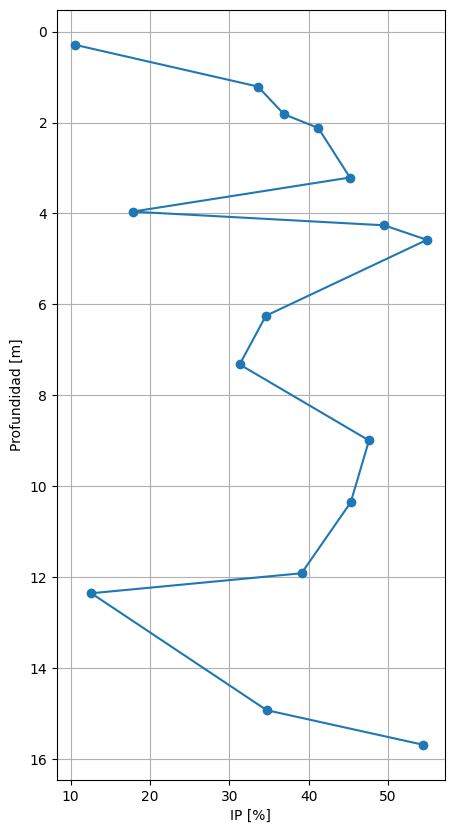

In [186]:
fig, ax = plt.subplots(1,1,figsize=(5,10))

ax.plot(limites["IP"],limites["Profundidad"],"-o")
ax.grid()
ax.invert_yaxis()
ax.set_xlabel("IP [%]")
ax.set_ylabel("Profundidad [m]")

Limitemos nuestro análisis al material que se encuentra entre 1 y 12m

In [187]:
limites = limites[(limites["Profundidad"]>=1) & (limites["Profundidad"]<=12)]
limites

,Profundidad,LP,LL,IP
1,1.21,17.8,51.4,33.6
2,1.82,11.8,48.7,36.9
3,2.12,22.4,63.6,41.2
4,3.21,15.6,60.8,45.2
5,3.96,14.8,32.6,17.8
6,4.26,26.5,76.0,49.5
7,4.58,18.9,73.8,54.9
8,6.25,15.7,50.3,34.6
9,7.32,11.1,42.4,31.3
10,8.99,24.0,71.6,47.6


Asumiendo una distribución normal para IP, calculamos la media y el desvío

In [188]:
mu_IP = limites["IP"].mean()
std_IP = limites["IP"].std()
cov_IP = std_IP/mu_IP
print(f'IP - Media={mu_IP:.1f}, Desvío={std_IP:.1f}, COV={cov_IP*100:.0f}%')

IP - Media=39.8, Desvío=9.9, COV=25%


Visualizamos distribución

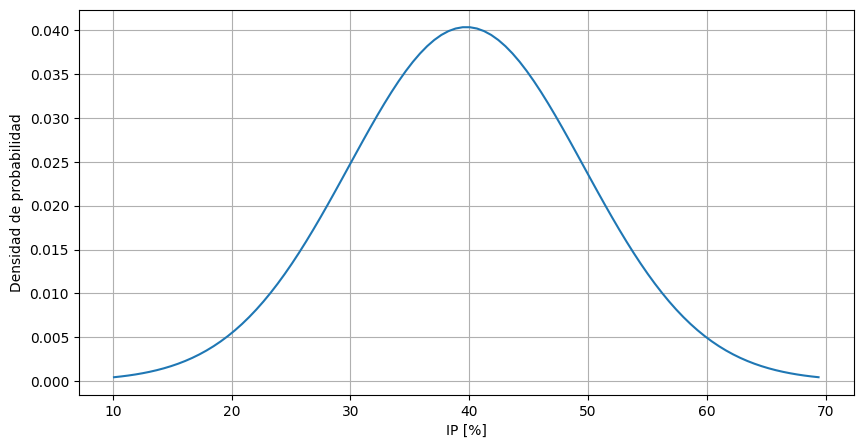

In [189]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ip_test = np.linspace(mu_IP-3*std_IP,mu_IP+3*std_IP,100)
ax.plot(ip_test, norm.pdf(ip_test, mu_IP, std_IP))
ax.set_xlabel("IP [%]")
ax.set_ylabel("Densidad de probabilidad");
ax.grid()

### Error en la correlación IP y $\phi_{cv}$

Nuevo ajuste: 

$sin(\phi_{cv})=0.76 - 0.092 \cdot ln(IP)$

Desvío estandar del error en el ajuste: 0.0575

Función de correlación

In [190]:
def correlacion(IP):
  err_dist = norm(0,0.05750601259054363)
  err = err_dist.rvs(IP.size)
  IP = 0.7672834390592754 - 0.09195319156055258 * np.log(IP)
  return IP + err

### Generación de muestras para el análisis

In [191]:
N=1000

#Genero las muestras de IP
IP_dist = norm(mu_IP,std_IP)
IP = IP_dist.rvs(N)

#Aplico la correlación
sin_phicv = correlacion(IP)

Visualizo la correlación

(<matplotlib.legend.Legend at 0x7ff1d170c6a0>,)

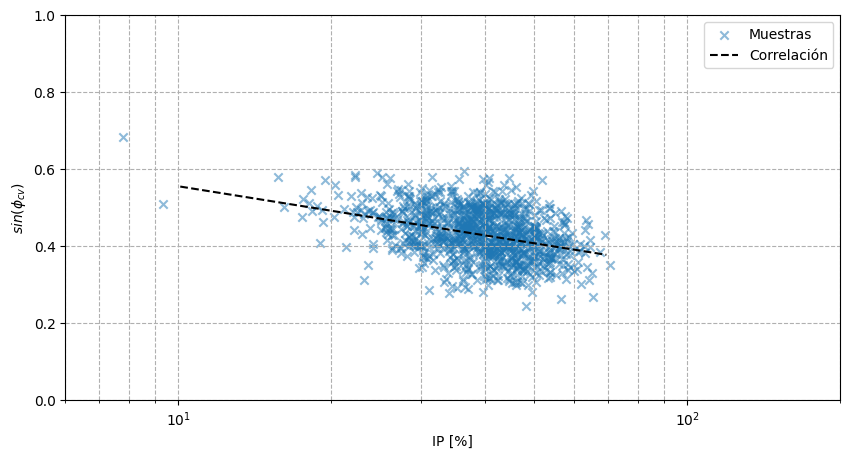

In [192]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.scatter(IP,sin_phicv,marker="x", alpha=0.50, label="Muestras") #data
ax.plot(ip_test,0.7672834390592754 - 0.09195319156055258 * np.log(ip_test), 'k--', label="Correlación")

ax.set_xlim(6,200)
ax.set_xscale('log')
ax.set_ylim([0,1])
ax.set_xlabel("IP [%]")
ax.set_ylabel("$sin(\phi_{cv})$")
ax.grid(True, which='both', linestyle='--')
ax.legend(),

En términos de histogramas

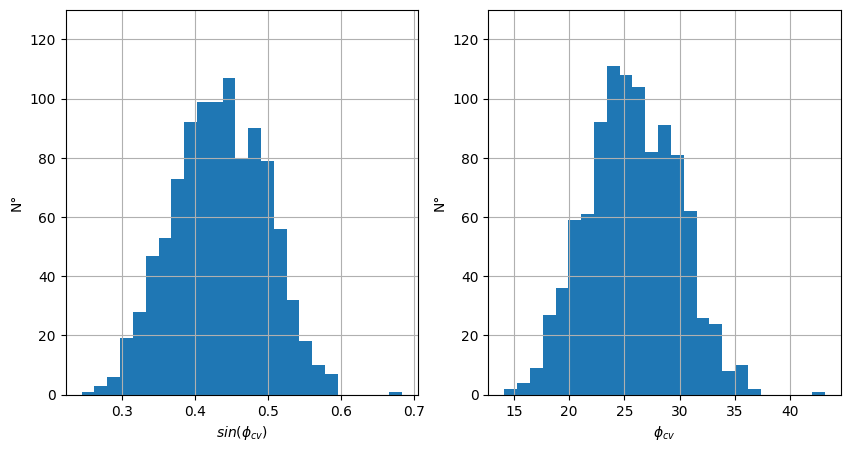

In [193]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

phicv = np.rad2deg(np.arcsin(sin_phicv))

axs[0].hist(sin_phicv, bins=25);
axs[1].hist(phicv, bins=25);
axs[0].set_xlabel("$sin(\phi_{cv})$")
axs[1].set_xlabel("$\phi_{cv}$")
for ax in axs:
  ax.set_ylabel("N°")
  ax.set_ylim([0,130])
  ax.grid()



Adoptamos una confianza del 84%

In [194]:
phicv_84 = np.percentile(phicv,16)

print(f'Phi_cv con confianza del 84%: {phicv_84:.1f}°')

Phi_cv con confianza del 84%: 21.6°


### Cálculo de la resistencia

No parece haber data suficiente sobre OCR para hacer un análisis estadístico medianamente serio, por lo que adoptamos OCR=5 igual que en el problema anterior.

$tan(\phi) \approx 1.2 \cdot \sqrt{ln (OCR)} \cdot tan(\phi_{cv})$

In [195]:
OCR=5
phi_84 = np.rad2deg(np.arctan(1.2 * np.sqrt(np.log(OCR))*np.tan(np.deg2rad(phicv_84))))

print(f'Phi con confianza del 84%: {phi_84:.1f}°')

Phi con confianza del 84%: 31.1°


In [196]:
#Limites de los estratos, en m
limites = [0,10]

# Peso propio, en kN/m3
gamma = [20]

# Ángulo de fricción
phi = [phi_84]

# Módulo de empuje horizontal
K = [0.75]

#Profundidad del nivel freático, en m
nf = 6

#Diametro del pilote, en m
D = 0.76

#Profundidad del pilote, en m
L = 10

#Cálculo
Qf = resistencia_por_fuste(L,limites,phi,gamma,K,nf,D)

print(f'Resistencia por fuste en condición drenada, Qf={Qf:.0f}kN')

Resistencia por fuste en condición drenada, Qf=671kN


Ejercicio: ver la confiablidad del valor obtenido por método determinístico.

## Resistencia no-drenada

### Importo datos de CPT

In [197]:
data_cpt = pd.read_csv("/content/cpt_punta.txt")
data_cpt

,Depth,Mean,SD,-SD,+1
0,0.00,0.00,0.00,0.00,0.01
1,0.05,0.00,0.23,0.00,0.23
2,0.10,0.50,0.64,0.00,1.14
3,0.15,1.15,1.04,0.11,2.19
4,0.20,1.66,1.15,0.51,2.82
...,...,...,...,...,...
310,15.50,6.38,0.38,6.00,6.76
311,15.55,6.16,1.39,4.77,7.55
312,15.60,6.66,2.37,4.29,9.04
313,15.65,7.88,3.89,4.00,11.77


### Resistencia característica

Si asumimos que el error del CPT tiene una distribución normal, una confiabilidad del 84% equivale a adoptar:

$q_t = \mu_{qt} - \sigma_{qt}$

In [198]:
data_cpt["qt_diseño"] = data_cpt["-SD"]
data_cpt["qt_diseño"][data_cpt["qt_diseño"]<0] = 0

data_cpt

,Depth,Mean,SD,-SD,+1,qt_diseño
0,0.00,0.00,0.00,0.00,0.01,0.00
1,0.05,0.00,0.23,0.00,0.23,0.00
2,0.10,0.50,0.64,0.00,1.14,0.00
3,0.15,1.15,1.04,0.11,2.19,0.11
4,0.20,1.66,1.15,0.51,2.82,0.51
...,...,...,...,...,...,...
310,15.50,6.38,0.38,6.00,6.76,6.00
311,15.55,6.16,1.39,4.77,7.55,4.77
312,15.60,6.66,2.37,4.29,9.04,4.29
313,15.65,7.88,3.89,4.00,11.77,4.00


Presión efectiva vertical

In [199]:
data_cpt["sigmav"] = data_cpt.apply(lambda x: tension_vertical_total(x.Depth,gamma,limites,nf,1), axis=1)

Resistencia no drenada del terreno

In [200]:
data_cpt["su_diseño"] = (data_cpt["qt_diseño"]*1000-data_cpt["sigmav"])/14

Resistencia no drenada del terreno (84%)

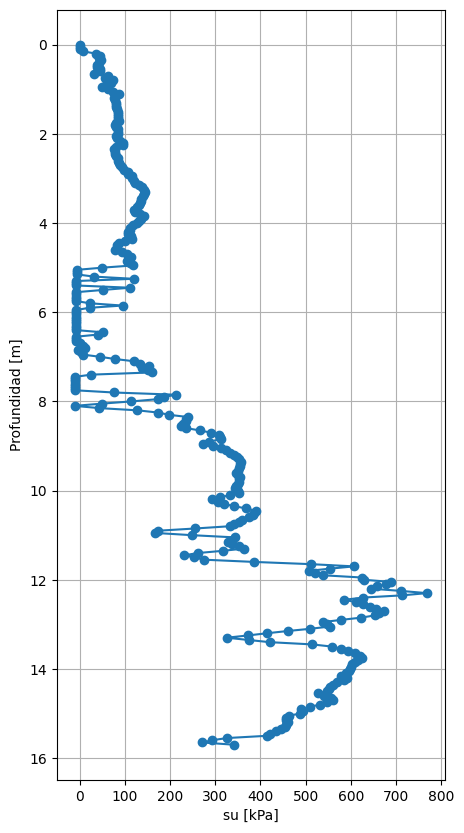

In [201]:
fig, ax = plt.subplots(1,1,figsize=(5,10))

ax.plot(data_cpt["su_diseño"],data_cpt["Depth"],"-o")
ax.grid()
ax.invert_yaxis()
ax.set_xlabel("su [kPa]")
ax.set_ylabel("Profundidad [m]");

Resistencia unitaria del fuste

Text(0, 0.5, 'Profundidad [m]')

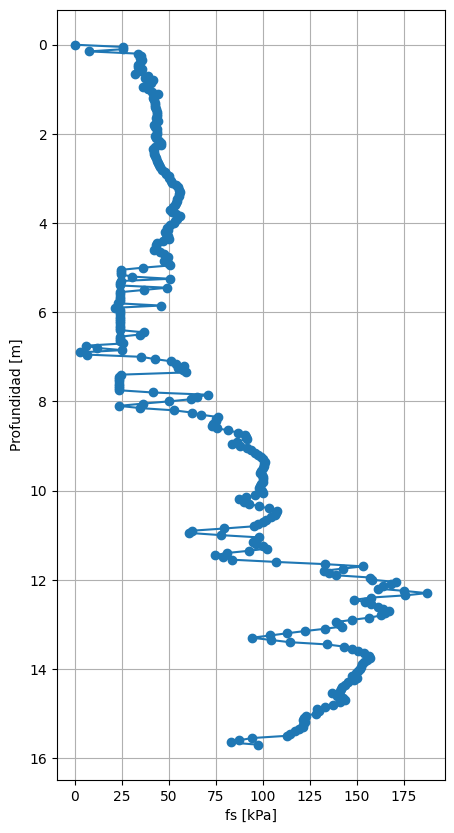

In [202]:
data_cpt['fs'] = data_cpt.apply(lambda x: fs_metodo_alpha(x.su_diseño), axis=1)

fig, ax = plt.subplots(1,1,figsize=(5,10))

ax.plot(data_cpt["fs"],data_cpt["Depth"],"-o")
ax.grid()
ax.invert_yaxis()
ax.set_xlabel("fs [kPa]")
ax.set_ylabel("Profundidad [m]")

### Creo una función de interpolación entre puntos

In [203]:
from scipy import interpolate

z = data_cpt["Depth"]
fs = data_cpt["fs"]

f = interpolate.interp1d(z,fs)

In [204]:
qf = quad(f,0,10,limit=1000)
Qf = qf[0]*per



<ipython-input-204-d41dab89a406>:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  qf = quad(f,0,10,limit=1000)


In [205]:
print(f'Resistencia por fuste en condición no-drenada, Qf={Qf:.0f}kN')

Resistencia por fuste en condición no-drenada, Qf=1157kN
